# Sensitivity to time scales


In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
import oggm
from oggm import cfg, utils, graphics
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, inversion, flowline, vascaling

In [2]:
# specify and create directory for plots
plot_dir = '/Users/oberrauch/work/master/plots/sensitivity'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# specify the RGI ID for Hintereisferner
rgi_id = 'RGI60-11.00897'
rgi_region = (rgi_id.split('-')[-1]).split('.')[0]
rgi_version = (rgi_id.split('-')[0])[-2:]

## Preprocessing

In [4]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-08-13 12:09:13: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


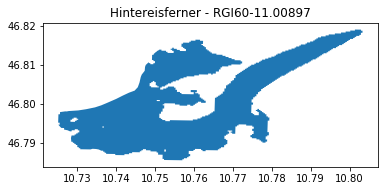

In [5]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id])
# quick look, to make sure we got the rigth one
entity.plot()
plt.title('Hintereisferner - ' + rgi_id)
# select the row containing HEF from DataFrame
entity = entity.iloc[0]

In [6]:
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

In [7]:
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [8]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2019-08-13 12:09:15: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-08-13 12:09:15: oggm.core.gis: (RGI60-11.00897) glacier_masks


In [9]:
# process the given climate file
climate.process_histalp_data(gdir)
# compute local temperature sensitivity, using t*=1927
vascaling.local_t_star(gdir, tstar=1927, bias=0)

2019-08-13 12:09:16: oggm.core.climate: (RGI60-11.00897) process_histalp_data
2019-08-13 12:09:19: oggm.core.vascaling: (RGI60-11.00897) local_t_star


## Mass balance model

In [10]:
# instance mass balance models
past_mb_mod = vascaling.VAScalingMassBalance(gdir)
rand_mb_mod = vascaling.RandomVASMassBalance(gdir, seed=12)
rand_mb_mod.temp_bias = .5
const_mb_mod = vascaling.ConstantVASMassBalance(gdir)
const_mb_mod.temp_bias = .5
# read climate/massbalance calibration file
local_mustar = gdir.read_json('vascaling_mustar')
ci = gdir.read_pickle('climate_info')
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

In [16]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds = model.run_until_equilibrium(ystep=10, time_scale_factor=10, rate=1e-4)
print(model)

<class 'oggm.core.vascaling.VAScalingModel'>
year: 250
area [km2]: 6.06
volume [km3]: 0.334
length [km]: 4.52
min elev [m asl.]: 2527
spec mb [mm w.e. yr-1]: 4.40


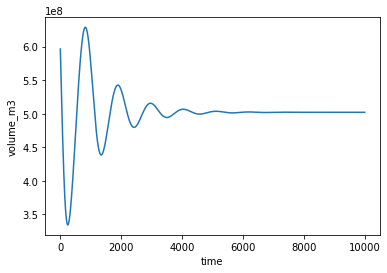

In [28]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds = model.run_until_and_store(year_end=1e4, time_scale_factor=10)
ds.volume_m3.plot()

[1111.22222222]


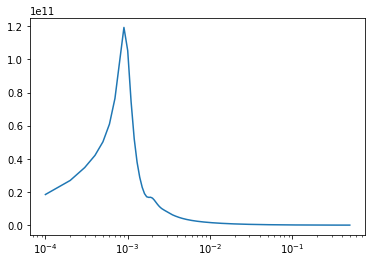

In [77]:
sig = ds.volume_m3.values.flatten()
freqs = np.fft.rfftfreq(sig.size)[1:]
y = np.abs(np.fft.rfft(sig))[1:]
plt.semilogx(freqs, y)
print(1/freqs[y == max(y)])

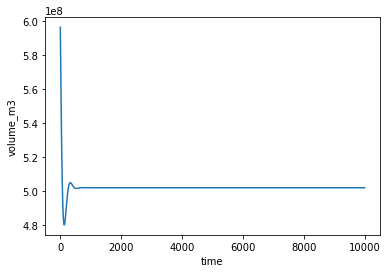

In [78]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds = model.run_until_and_store(year_end=1e4, time_scale_factor=1)
ds.volume_m3.plot()

[333.36666667]


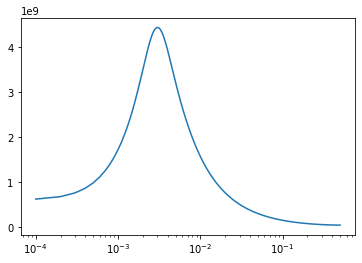

In [79]:
sig = ds.volume_m3.values.flatten()
freqs = np.fft.rfftfreq(sig.size)[1:]
y = np.abs(np.fft.rfft(sig))[1:]
plt.semilogx(freqs, y)
print(1/freqs[y == max(y)])

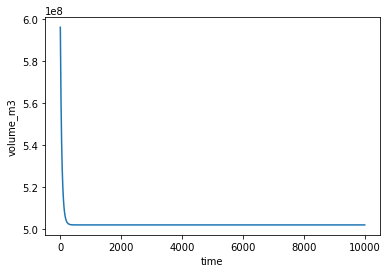

In [82]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds = model.run_until_and_store(year_end=1e4, time_scale_factor=0.1)
ds.volume_m3.plot()

[10001.]


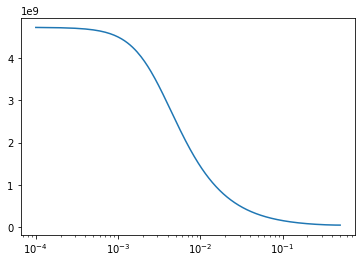

In [81]:
sig = ds.volume_m3.values.flatten()
freqs = np.fft.rfftfreq(sig.size)[1:]
y = np.abs(np.fft.rfft(sig))[1:]
plt.semilogx(freqs, y)
print(1/freqs[y == max(y)])

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  .format(nperseg, input_length))


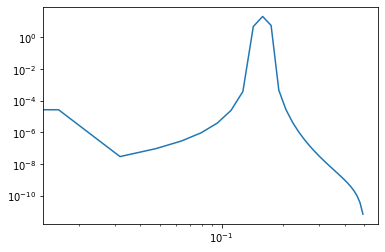

In [64]:
# load module for the spectral analysis
from scipy import signal

x = np.arange(0,10*2*np.pi)
sig = np.sin(x)
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd)


plt.loglog(freqs, fft)

In [59]:
Y = np.fft.fft(sig, n=100)

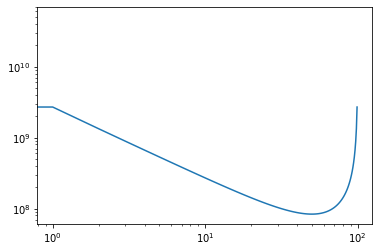

In [62]:
plt.loglog(np.abs(Y))

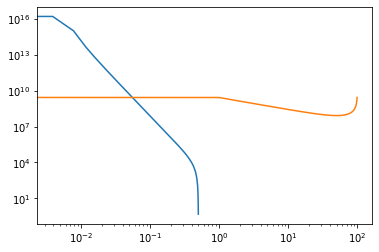

In [63]:
# load module for the spectral analysis
from scipy import signal

sig = ds.volume_m3.values.flatten()
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd)
plt.loglog(np.abs(Y))

In [44]:
freqs[psd == max(psd)]

array([0.15873016])

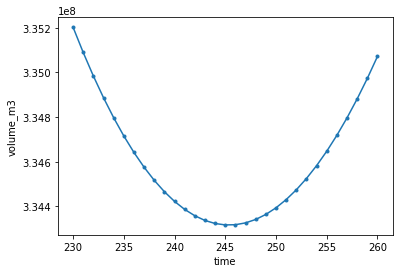

In [27]:
volume = ds.volume_m3.copy()
volume.sel(time=slice(230,260)).plot(marker='.')

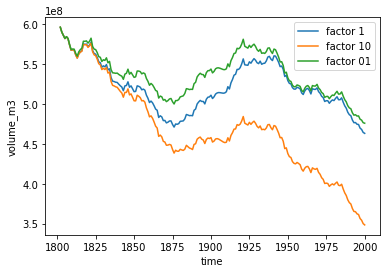

In [38]:
model = vascaling.VAScalingModel(year_0=ci['baseline_hydro_yr_0'],
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=past_mb_mod)
ds = model.run_until_and_store(year_end=2000, time_scale_factor=1)

model = vascaling.VAScalingModel(year_0=ci['baseline_hydro_yr_0'],
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=past_mb_mod)
ds_10 = model.run_until_and_store(year_end=2000, time_scale_factor=10)

model = vascaling.VAScalingModel(year_0=ci['baseline_hydro_yr_0'],
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=past_mb_mod)
ds_01 = model.run_until_and_store(year_end=2000, time_scale_factor=0.1)

ds.volume_m3.plot(label='factor 1')
ds_10.volume_m3.plot(label='factor 10')
ds_01.volume_m3.plot(label='factor .1')
plt.legend()

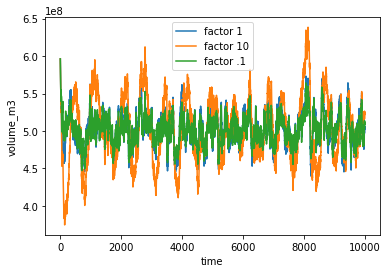

In [45]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=rand_mb_mod)
ds = model.run_until_and_store(year_end=1e4, time_scale_factor=1)

model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=rand_mb_mod)
ds_10 = model.run_until_and_store(year_end=1e4, time_scale_factor=5)

model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=rand_mb_mod)
ds_01 = model.run_until_and_store(year_end=1e4, time_scale_factor=0.1)

ds.volume_m3.plot(label='factor 1')
ds_10.volume_m3.plot(label='factor 10')
ds_01.volume_m3.plot(label='factor .1')
plt.legend()

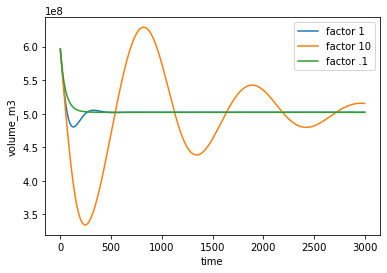

In [48]:
model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds = model.run_until_and_store(year_end=3e3, time_scale_factor=1)

model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds_10 = model.run_until_and_store(year_end=3e3, time_scale_factor=10)

model = vascaling.VAScalingModel(year_0=0,
                                 area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=const_mb_mod)
ds_01 = model.run_until_and_store(year_end=3e3, time_scale_factor=0.1)

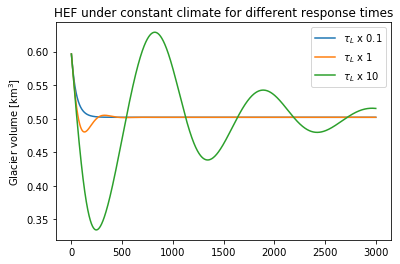

In [58]:
(ds_01.volume_m3/1e9).plot(label=r'$\tau_L$ x 0.1')
(ds.volume_m3/1e9).plot(label=r'$\tau_L$ x 1')
(ds_10.volume_m3/1e9).plot(label=r'$\tau_L$ x 10')

plt.title('HEF under constant climate for different response times')
plt.xlabel('')
plt.ylabel('Glacier volume [km$^3$]')

plt.legend()

In [27]:
# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
tstar = gdir.read_json('vascaling_mustar')['t_star']
# use t* = 1927, coherent with eq runs
tstar = 1927
vascaling.local_t_star(gdir, tstar=tstar, bias=0)

# instance the mass balance models
temp_bias = 0.5
eq_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod.temp_bias = -temp_bias
neg_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
neg_mb_mod.temp_bias = +temp_bias

2019-08-05 14:51:59: oggm.core.vascaling: (RGI60-11.00897) local_t_star
2019-08-05 14:51:59: oggm.core.vascaling: (RGI60-11.00897) local_t_star


In [56]:
pos_mb

196.08307524650328

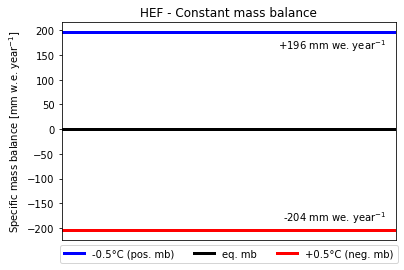

In [90]:
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
# compute mass balance
pos_mb = pos_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
eq_mb = eq_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
neg_mb = neg_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
# visualize
#fig, ax = plt.subplots(1,1, figsize=[6,4])
plt.axhline(pos_mb, c='b', label='-0.5°C (pos. mb)', lw=3)
plt.axhline(eq_mb, c='k', label='eq. mb', lw=3)
plt.axhline(neg_mb, c='r', label='+0.5°C (neg. mb)', lw=3)
plt.legend(ncol=3, bbox_to_anchor=(0.5, 0), loc='upper center')
plt.title('HEF - Constant mass balance')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xticks([]);
# add exact numbers as text/annotation
plt.text(0.97, pos_mb*0.95, '{:+.0f} mm we. year$^{{-1}}$'.format(pos_mb), ha='right', va='top')
plt.text(0.97, neg_mb*0.95, '{:+.0f} mm we. year$^{{-1}}$'.format(neg_mb), ha='right', va='bottom')
# save plot to file
plt.savefig(os.path.join(plot_dir, 'constant_mb.pdf'), bbox_inches='tight')

In [146]:
# let the model evolve for 1000 years under the different cliamte scenarios
n_years = 1000
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, eq_mb_mod)
ds_eq = model.run_until_and_store(n_years)
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, pos_mb_mod)
ds_pos = model.run_until_and_store(n_years)
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, neg_mb_mod)
ds_neg = model.run_until_and_store(n_years)

In [147]:
def ds_stats(ds, var):
    return ds[var].to_dataframe().describe()[np.atleast_1d(var)]

In [117]:
stats_pos = ds_stats(ds_pos, 'volume_m3')
stats_neg = ds_stats(ds_neg, 'volume_m3')
stats = pd.concat([stats_pos, stats_neg], axis=1)
stats.columns = ['pos', 'neg']
stats

,pos,neg
count,1.001000e+03,1.001000e+03
mean,6.972823e+08,5.026532e+08
std,1.740654e+07,1.449960e+07
min,5.962979e+08,4.802169e+08
25%,6.970052e+08,5.016985e+08
50%,6.973081e+08,5.020431e+08
75%,6.980501e+08,5.022496e+08
max,7.295884e+08,5.962979e+08


In [148]:
print(ds_pos.isel(time=slice(900,1001)).mean()['volume_m3'])
print(ds_neg.isel(time=slice(900,1001)).mean()['volume_m3'])

<xarray.DataArray 'volume_m3' ()>
array(6.973136e+08)
<xarray.DataArray 'volume_m3' ()>
array(5.020413e+08)


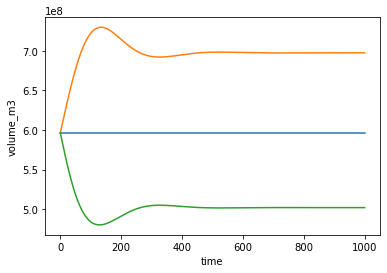

In [118]:
ds_eq.volume_m3.plot()
ds_pos.volume_m3.plot()
ds_neg.volume_m3.plot()

In [173]:
# normalize the results
ds_eq = ds_eq/ds_eq.isel(time=0)
ds_pos = ds_pos/ds_pos.isel(time=0)
ds_neg = ds_neg/ds_neg.isel(time=0)

In [124]:
stats_pos = ds_stats(ds_pos, 'volume_m3')
stats_neg = ds_stats(ds_neg, 'volume_m3')
stats = pd.concat([stats_pos, stats_neg], axis=1)
stats.columns = ['pos', 'neg']
stats

,pos,neg
count,1001.000000,1001.000000
mean,1.169352,0.842957
std,0.029191,0.024316
min,1.000000,0.805331
25%,1.168888,0.841356
50%,1.169396,0.841933
75%,1.170640,0.842280
max,1.223530,1.000000


In [145]:
print(ds_pos.isel(time=slice(900,1001)).mean()['volume_m3'])
print(ds_neg.isel(time=slice(900,1001)).mean()['volume_m3'])

<xarray.DataArray 'volume_m3' ()>
array(1.169405)
<xarray.DataArray 'volume_m3' ()>
array(0.84193)


In [174]:
import xarray as xr

In [188]:
ds = xr.concat([ds_pos, ds_eq, ds_neg])
ds['concat_dims'] = [-0.5, 0, +0.5]
ds['normalized'] = True
ds.rename({'concat_dims': 'temp_bias'}, inplace=True)


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  """Entry point for launching an IPython kernel.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  after removing the cwd from sys.path.


<xarray.Dataset>
Dimensions:         (temp_bias: 3, time: 1001)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
  * temp_bias       (temp_bias) float64 -0.5 0.0 0.5
Data variables:
    volume_m3       (temp_bias, time) float64 1.0 1.003 1.006 ... 0.8419 0.8419
    area_m2         (temp_bias, time) float64 1.0 1.0 1.0 ... 0.8824 0.8824
    length_m        (temp_bias, time) float64 1.0 1.0 1.0 ... 0.9248 0.9248
    ela_m           (temp_bias, time) float64 nan nan nan nan ... nan nan nan
    spec_mb         (temp_bias, time) float64 1.0 1.0 ... -4.421e-05 -4.421e-05
    min_hgt         (temp_bias, time) float64 1.0 1.0 1.0 ... 1.039 1.039 1.039
    tau_l           (temp_bias, time) float64 1.0 52.33 52.48 ... 49.93 49.93
    tau_a           (temp_bias, time) float64 1.0 17.55 17.6 ... 17

In [196]:
def plot_time_series(ds, var, title=''):
    # plot relative volume change
    fig, ax0 = plt.subplots(1, 1)

    # vas model
    ax0.set_prop_cycle('color', ['b', 'k', 'r'])
    handles_vas = ds[var].plot(hue='temp_bias', ax=ax0, add_legend=False, lw=2)
    labels_vas = ['{:+.1f} °C'.format(bias) for bias in ds.temp_bias.values]
    
    # set axes limits
    ax0.set_xlim([ds.time.min(), ds.time.max()])
    ylim = ax0.get_ylim()
    ax0.set_ylim([ylim[0]*0.9, ylim[1]])
    
    # title, labels, legend
    ax0.set_title('HEF - Volume area scaling model evolution')
    ax0.set_xlabel('Years of model evolution')
    ax0.legend(handles_vas, labels_vas, title='Temperature bias',
           bbox_to_anchor=(0.5, 0), loc=8, ncol=3)
    if ds.normalized:
        # add ylabel
        ax0.set_ylabel('Relative {}'.format(var[:-3]))
        # aux line
        ax0.axhline(1, lw=0.8, ls=':', c='k')
    else:
        # add ylabel
        unit = 'm' if var == 'length' else 'm$^2$' if var == 'area' else 'm$^3$'
        ax0.set_ylabel('Glacier {} [{}]'.format(var[:-3], unit))
        # aux line
        ax0.axhline(ds[var].isel(time=0).mean(), lw=0.8, ls=':', c='k')
        
    ax0.grid()
    
    plt.savefig(os.path.join(plot_dir, 'volume_norm.pdf'), bbox_inches='tight')

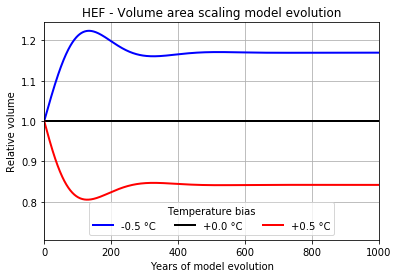

In [197]:
plot_time_series(ds, 'volume_m3')


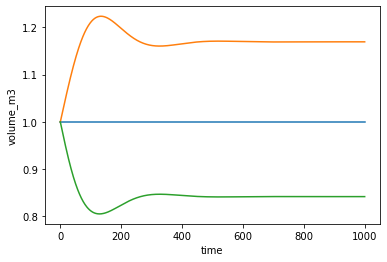

In [125]:
ds_eq.volume_m3.plot()
ds_pos.volume_m3.plot()
ds_neg.volume_m3.plot()

In [10]:
# define range of temp biases
temp_bias = np.arange(-50, 50.1, 0.1)
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=temp_bias, columns=['spec_mb'])

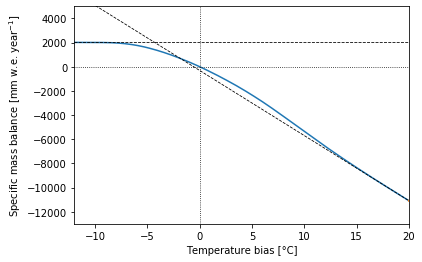

In [26]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

ax.plot(const_mb)
# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xlim([-12,20])
plt.ylim([-1.3e4,0.5e4])

# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax.plot(x, y, ls='--', c='k', lw=0.8)
ax.plot(x[x >= 20],
         y[x >= 20],
         ls='-', c='C1', lw=2, label='linear approx')
y = const_mb.iloc[:20].mean()[0]
ax.axhline(y, ls='--', c='k', lw=0.8)


Compute linear approximation near 0°C temperature bias...

In [15]:
from sklearn import linear_model

x = const_mb.loc[(temp_bias >= 20)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999699711
intercept: [-313.47782632]
slope: [[-539.08952389]]


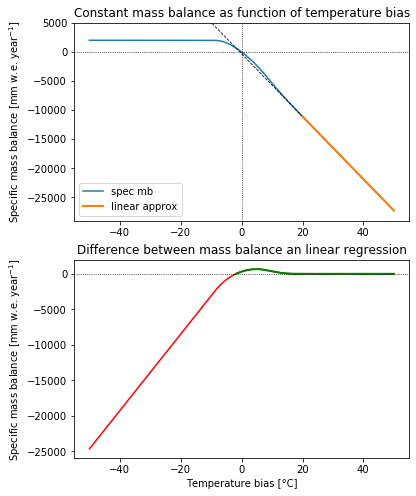

In [28]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[x >= 20],
         y[x >= 20],
         ls='-', c='C1', lw=2, label='linear approx')
ax0.set_ylim([-29000, 5000])

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_slope.pdf'), bbox_inches='tight')

In [29]:
gdir.read_json('vascaling_mustar')

{'rgi_id': 'RGI60-11.00897',
 't_star': 1927,
 'bias': 0,
 'mu_star': 44.92405670021741}

In [27]:
lin_mod.coef_

array([[-539.08952389]])

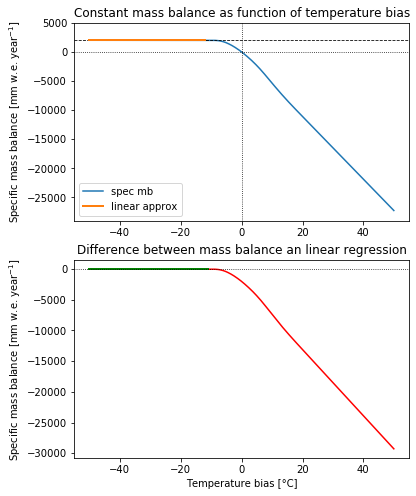

In [391]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = const_mb.iloc[:20].mean()[0]
ax0.axhline(y, ls='--', c='k', lw=0.8)
ax0.plot([-50, -12], [y, y],
         ls='-', c='C1', lw=2, label='linear approx')
ax0.set_ylim([-29000, 5000])

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_const.pdf'), bbox_inches='tight')

In [407]:
# define range of temp biases
bias_limit = 5
temp_bias = np.arange(-bias_limit, bias_limit+0.1, 0.1)
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=temp_bias, columns=['spec_mb'])

In [444]:
cfg.PARAMS['temp_all_solid']

0.0

In [448]:
cfg.PARAMS['temp_default_gradient']

-0.0065

In [447]:
vascaling.get_min_max_elevation(gdir)

(2430.0, 3685.0)

In [446]:
cfg.PARAMS['temp_all_liq']

2.0

In [445]:
cfg.PARAMS['temp_melt']

-1.75

In [443]:
gdir.read_json('vascaling_mustar')

{'rgi_id': 'RGI60-11.00897',
 't_star': 1927,
 'bias': 0,
 'mu_star': 44.92405670021741}

In [408]:
from sklearn import linear_model

bias_limit = 1
x = const_mb.loc[(temp_bias >= -(bias_limit+0.01)) & (temp_bias <= bias_limit)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9995220649376573
intercept: [-5.89756071]
slope: [[-400.14623192]]


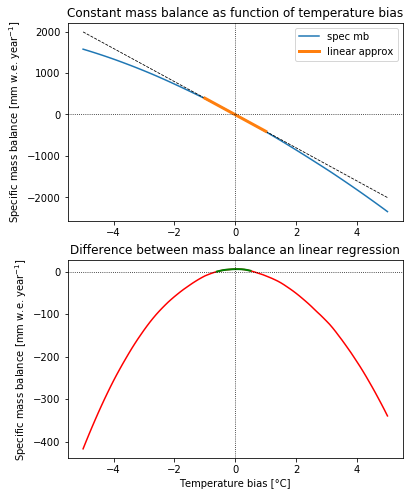

In [442]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         y[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         ls='-', c='C1', lw=3, label='linear approx')

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.axvline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

fig.savefig(os.path.join(plot_dir, 'lin_reg_detail.pdf'), bbox_inches='tight')

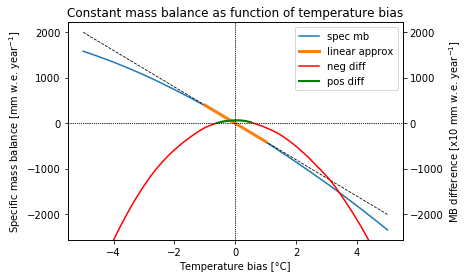

In [441]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1)

# plot mass balance
ax0.plot(const_mb, label='spec mb')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         y[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         ls='-', c='C1', lw=3, label='linear approx')

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')

# get secondary y axisx
ax1 = ax0.twinx()

# compute and plot differences in spec mb
dif = (const_mb.values.flatten() - y) * 10
ax1.plot(x, dif, c='r', label='neg diff')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2, label='pos diff')
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.axvline(0, c='k', ls=':', lw=0.8)
ax0.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('MB difference [x10 mm w.e. year$^{-1}$]')
ax1.set_ylim(ax0.get_ylim())

h = np.array([h for h, l in [ax0.get_legend_handles_labels(), ax1.get_legend_handles_labels()]]).flatten()
l = np.array([l for h, l in [ax0.get_legend_handles_labels(), ax1.get_legend_handles_labels()]]).flatten()
ax1.legend(h, l)

fig.savefig(os.path.join(plot_dir, 'lin_reg_detail_oneplot.pdf'), bbox_inches='tight')

The constant mass balance can be approximate by a linear function for temperature biases between -1°C and 1°C, with a coefficient of determination of 0.9995.

Take a quick look at the precipiation bias...

In [397]:
# define range of temp biases
prcp_bias = np.unique(np.sort(np.concatenate([1/np.arange(1,10+1), np.arange(1,10+1)])))
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in prcp_bias:
    # add temperature bias
    const_mb_mod.prcp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=prcp_bias, columns=['spec_mb'])

In [398]:
from sklearn import linear_model

bias_limit = None
x = const_mb
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999999999
intercept: [-1417.9698291]
slope: [[1417.96987652]]


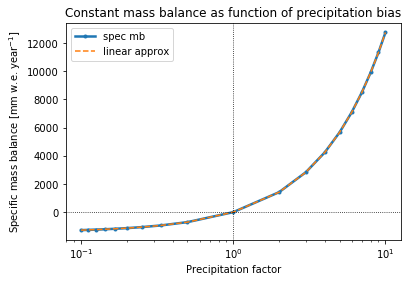

In [403]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

#
ax.semilogx(const_mb, marker='.', lw=2.5, label='spec mb')
ax.plot(prcp_bias, lin_mod.coef_[0] * prcp_bias + lin_mod.intercept_, label='linear approx', ls='--')

# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(1, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Precipitation factor')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax.set_title('Constant mass balance as function of precipitation bias')
ax.legend()

fig.savefig(os.path.join(plot_dir, 'lin_reg_prcp.pdf'), bbox_inches='tight')


## Glacier evlution model
TODO:...

In [14]:
# model = vascaling.VAScalingModel()

## Random climate (mass balance) model
The `RandomVASMassBalance` model is a good tool to investigate/understand the model behavior. It takes climate information from a randomly chosen year within a 31-year period of a specified year `y0` to compute the specific mass balance. Hence, the model runs on a synthetic climate based on actual observations.

If we choose the climatological period around the "equilibrium" year $t^*$ the model glacier should stay in equilibirum. The `run_random_climate` task allows to add a temperature bias. Increasing/decresing the temperature of the equilibirum period should result in a retreating/advancing model glacier, which reaches a new equilibrium after some years.

In [15]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star = gdir.read_json('vascaling_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, seed=12, output_filesuffix='_normal')
vascaling.run_random_climate(gdir, nyears=3000, y0=t_star, seed=12, output_filesuffix='_longtime')
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_bias_p')
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_bias_m');

2019-07-03 13:47:09: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_normal
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 13:47:10: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_longtime
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 13:47:12: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_bias_p
2019-07-03 13:47:13: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_bias_m


Each task writes its output in a different file (specified by the suffix). To work with produced data, the output must be compiled (i.e., converted into a `xarray.dataset`). In this notebook we work only on a single glacier, however the `compile_run_output` task handels multiple glaciers (represented by `GlacierDirectorie`s at once).

In [16]:
def normalize_with_start(ds):
    """Normalize all data variables with their respecitve first entry.
    Retrurn a new xarray.dataset. """
    # copy the given dataset
    ds_ = ds.copy()
    # iterate over all data variables
    for var in ds_.data_vars:
        # normalize with start value
        ds_[var] = ds_[var]/ds_[var][0]
    # return normalized dataset
    return ds_

In [18]:
# compile the run output and normalize glacier geometries with start value
ds = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_normal'))
ds_longtime = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_longtime'))
ds_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_bias_p'))
ds_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_bias_m'))

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


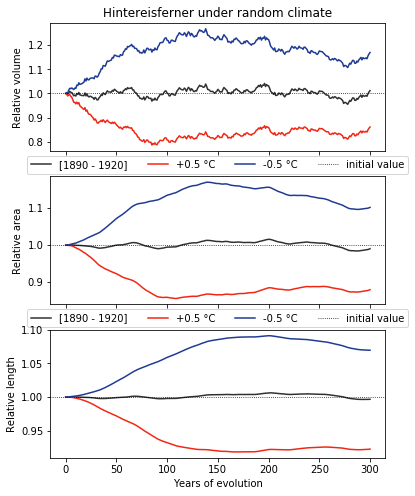

In [19]:
# create figure and axes
fig, [ax0, ax1, ax2] = plt.subplots(3,1, figsize=[6,8])
# plot the evolution of glacier volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax0.plot(ds_p.volume, label='+0.5 °C', c='#f22613')
ax0.plot(ds_m.volume, label='-0.5 °C', c='#1f3a93')
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8, label='initial value')
ax0.set_xticklabels('')
ax0.set_ylabel('Relative volume')
ax0.set_title('Hintereisferner under random climate')
ax0.legend(bbox_to_anchor=(0.5, 0), loc=9, ncol=4)

# plot the evolution of glacier area
ax1.plot(ds.area, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax1.plot(ds_p.area, label='+0.5 °C', c='#f22613')
ax1.plot(ds_m.area, label='-0.5 °C', c='#1f3a93')
ax1.axhline(ds.area[0], c='k', ls=':', lw=0.8, label='initial value')
ax1.set_xticklabels('')
ax1.set_ylabel('Relative area')
ax1.legend(bbox_to_anchor=(0.5, 0), loc=9, ncol=4)

# plot the evolution of glacier length
ax2.plot(ds.length, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax2.plot(ds_p.length, label='+0.5 °C', c='#f22613')
ax2.plot(ds_m.length, label='-0.5 °C', c='#1f3a93')
ax2.axhline(ds.length[0], c='k', ls=':', lw=0.8, label='initial value')
ax2.set_xlabel('Years of evolution')
ax2.set_ylabel('Relative length')

fig.savefig('hef_random_climate.jpg', bbox_inches='tight')

## Compare with OGGM

In [20]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 100
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-07-03 14:06:52: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [21]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id]).iloc[0]
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [22]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2019-07-03 14:06:58: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-07-03 14:06:58: oggm.core.gis: (RGI60-11.00897) glacier_masks


In [23]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-07-03 14:07:00: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-07-03 14:07:01: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-07-03 14:07:03: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2019-07-03 14:07:06: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2019-07-03 14:07:10: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-07-03 14:07:19: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-07-03 14:07:20: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-07-03 14:07:29: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


In [24]:
# compute the mass balance parameters for the OGGM model
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

2019-07-03 14:07:29: oggm.core.climate: (RGI60-11.00897) process_histalp_data
2019-07-03 14:07:34: oggm.core.climate: (RGI60-11.00897) local_t_star
2019-07-03 14:07:34: oggm.core.climate: (RGI60-11.00897) local mu* computation for t*=1927
2019-07-03 14:07:35: oggm.core.climate: (RGI60-11.00897) mu_star_calibration


In [25]:
# run inversion tasks
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) filter_inversion_output


In [26]:
# final task
flowline.init_present_time_glacier(gdir)

2019-07-03 14:07:36: oggm.core.flowline: (RGI60-11.00897) init_present_time_glacier


In [ ]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star_oggm = gdir.read_json('local_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, seed=12, output_filesuffix='_oggm')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_oggm_bias_p')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_oggm_bias_m');

2019-07-03 15:16:31: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm
2019-07-03 15:16:33: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [32]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star_oggm = gdir.read_json('local_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = True
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, seed=12, output_filesuffix='_oggm_mbbias')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_oggm_mbbias_bias_p')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_oggm_mbbias_bias_m');

2019-07-03 15:16:31: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm
2019-07-03 15:16:33: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 15:18:24: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2019-07-03 15:18:24: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm_bias_p
2019-07-03 15:18:25: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 15:20:25: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2019-07-03 

KeyboardInterrupt: 

In [ ]:
ds_oggm = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm'))
ds_oggm_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_bias_p'))
ds_oggm_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_bias_m'))

In [ ]:
ds_oggm_mbbias = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias'))
ds_oggm_mbbias_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias_bias_p'))
ds_oggm_mbbias_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias_bias_m'))

In [ ]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])
# plot the evolution of glacier volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax0.plot(ds_p.volume, label='+0.5 °C', c='#f22613')
ax0.plot(ds_m.volume, label='-0.5 °C', c='#1f3a93')
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8, label='initial volume')
ax0.set_ylabel('Relative volume')
ax0.set_title('Volume/Area scaling model')
ax0.legend()
ax1.plot(ds_oggm.volume, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#6c7a89')
ax1.plot(ds_oggm_p.volume, label='+0.5 °C', c='#f89406')
ax1.plot(ds_oggm_m.volume, label='-0.5 °C', c='#2c82c9')
ax1.axhline(ds_oggm.volume[0], c='k', ls=':', lw=0.8, label='initial volume')
ax1.set_ylabel('Volume [km$^3$]')
ax1.set_title('Relative volume')
ax1.legend()

fig.savefig('vas_oggm_random.pdf', bbox_inches='tight')

In [ ]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1, figsize=[8,4])

# plot normalized vas volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#1f3a93', lw=2)
ax0.plot(ds_p.volume, label='+0.5 °C', c='#4d13d1', lw=2)
ax0.plot(ds_m.volume, label='-0.5 °C', c='#19b5fe', lw=2)

# add aux line at 1
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8)

# plot normalized oggm volume
ax0.plot(ds_oggm.volume, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#d35400', ls='-.', lw=1.5)
ax0.plot(ds_oggm_p.volume, label='+0.5 °C', c='#cf000f', ls='-.', lw=1.5)
ax0.plot(ds_oggm_m.volume, label='-0.5 °C', c='#fcd670', ls='-.', lw=1.5)

# add legend(s)
handels, labels = ax0.get_legend_handles_labels()
l_vas = ax0.legend(handels[:3], labels[:3], title='VAS model', bbox_to_anchor=(1, 1), loc=2)
l_vas.get_title().set_fontweight('bold')
l_oggm = ax0.legend(handels[3:], labels[3:], title='OGGM', bbox_to_anchor=(1, 0), loc=3)
l_oggm.get_title().set_fontweight('bold')
ax0.add_artist(l_vas)

# title, labels, ...
ax0.set_title('Evolution of HEF volume under random (equilibrium) climate')
ax0.set_xlabel('Years of evolution')
ax0.set_ylabel('Relative glacier volume')

# store to file
fig.savefig('vas_oggm_random_oneplot.jpg', bbox_inches='tight')

In [ ]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1, figsize=[8,4])

# plot normalized vas length
ax0.plot(ds.length, label='[{} - {}]'.format(t_star-15, t_star+15), c='#1f3a93', lw=2)
ax0.plot(ds_p.length, label='+0.5 °C', c='#4d13d1', lw=2)
ax0.plot(ds_m.length, label='-0.5 °C', c='#19b5fe', lw=2)

# add aux line at 1
ax0.axhline(ds.length[0], c='k', ls=':', lw=0.8)

# plot normalized oggm length
ax0.plot(ds_oggm.length, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#d35400', ls='-.', lw=1.5)
ax0.plot(ds_oggm_p.length, label='+0.5 °C', c='#cf000f', ls='-.', lw=1.5)
ax0.plot(ds_oggm_m.length, label='-0.5 °C', c='#fcd670', ls='-.', lw=1.5)

# add legend(s)
handels, labels = ax0.get_legend_handles_labels()
l_vas = ax0.legend(handels[:3], labels[:3], title='VAS model', bbox_to_anchor=(1, 1), loc=2)
l_vas.get_title().set_fontweight('bold')
l_oggm = ax0.legend(handels[3:], labels[3:], title='OGGM', bbox_to_anchor=(1, 0), loc=3)
l_oggm.get_title().set_fontweight('bold')
ax0.add_artist(l_vas)

# title, labels, ...
ax0.set_title('Evolution of HEF length under random (equilibrium) climate')
ax0.set_xlabel('Years of evolution')
ax0.set_ylabel('Relative glacier length')

# store to file
fig.savefig('vas_oggm_random_oneplot.jpg', bbox_inches='tight')

### Power spectrum

In [ ]:
# load module for the spectral analysis
from scipy import signal

In [ ]:
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=3000, y0=t_star_oggm, seed=12, output_filesuffix='_oggm')

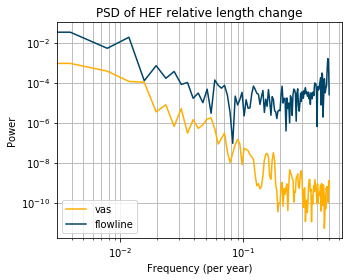

In [498]:
# visualize the results
plt.figure(figsize=(5, 4))

# compute the power of the signel per frequency band
sig = ds_lo.length.values.flatten()
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd, label='vas', c='#FFAE03')

# compute the power of the signel per frequency band
sig = ds_oggm.length.values.flatten()
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd, label='flowline', c='#004468')

plt.title('PSD of HEF relative length change')
plt.xlabel('Frequency (per year)')
plt.ylabel('Power')
plt.tight_layout()
plt.grid(which='both')
plt.legend()

## Finding a historic start area
TODO...

In [27]:
res = vascaling.find_start_area(gdir, year_start=t_star)
res

2019-06-25 16:58:44: oggm.core.vascaling: (RGI60-11.00897) find_start_area
2019-06-25 16:58:44: oggm.core.vascaling: FileNotFoundError occurred during task find_start_area on RGI60-11.00897: [Errno 2] No such file or directory: '/var/folders/dc/r0qdkr9n45n4c2f2cc7v7pfr0000gn/T/OGGM/VAS_HEF_wdir/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/vascaling_mustar.json'


FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/dc/r0qdkr9n45n4c2f2cc7v7pfr0000gn/T/OGGM/VAS_HEF_wdir/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/vascaling_mustar.json'

In [ ]:
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, seed=12, init_area_m2=res.x, output_filesuffix='_init')

In [ ]:
ds_init = utils.compile_run_output([gdir], filesuffix='_init')

In [ ]:
ax = plt.subplot(1,1,1)
ax.plot(ds.area, label='')
ax.plot(ds_init.area)

In [ ]:
ds.volume.plot()